# Train Model

### Notes:

1. considering how much upsampling is going in in each channels for accounting for the perception of each frequency band... I could get away with downsampling the whole thing in the frequency direction by a factor of 4, 8 or even 16, reducing the sample rate post upsample.... this could worth for both the masking model and the diffusion model easily, reducing the image size from (1024, 175) to (128, 175)

Next Steps:

2. Compare custom res-net model with attention as masking with deeplabv3_resnet50 altered. To complete the project, compare:
3. a) Custom simple, b) custom complex, c) deeplabv3_resnet50 d) lraspp_mobilenet_v3_large e) segformer
4. run test and get results
5. Write small extract on findings, and put into markdown on github.

In [1]:
import sys
import os

# Detect Google Colab
if "google.colab" in sys.modules:
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Detect Google Colab
if "google.colab" in sys.modules:
    print("Running in Google Colab...")
    os.system("git clone https://github.com/CiaranMaloy/audioautoencoder")
    os.chdir("/content/audioautoencoder/")
    os.system("git pull")
    os.system("git checkout bandchannels")
    os.system("git pull origin bandchannels")
    #os.system("pip install --upgrade torchmetrics")
else:
    print("Running locally...")
    os.system("git pull origin bandchannels")
    #os.system("pip install --upgrade torchmetrics")


Running in Google Colab...


In [3]:
import sys
sys.path.append('/content/audioautoencoder')
sys.path.append('/content/audioautoencoder/audioautoencoder')

## Define Model

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision.models._utils import IntermediateLayerGetter

# Step 1: Load the original ResNet50 backbone with pretrained weights
resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# Step 2: Modify the first convolution (conv1) to accept 4 channels
old_conv = resnet.conv1
new_conv = nn.Conv2d(
    9,
    old_conv.out_channels,
    kernel_size=old_conv.kernel_size,
    stride=old_conv.stride,
    padding=old_conv.padding,
    bias=False
)
with torch.no_grad():
    # Copy the weights for the first 3 channels
    new_conv.weight[:, :3, :, :] = old_conv.weight
    # For the 4th channel, use the mean of the original weights
    new_conv.weight[:, 3:, :, :] = old_conv.weight.mean(dim=1, keepdim=True)
resnet.conv1 = new_conv

# Step 3: Create a new backbone using IntermediateLayerGetter
# We extract the layers needed by DeepLabV3 (by default, "layer1" and "layer4")
return_layers = {'layer1': 'low_level_features', 'layer4': 'out'}
backbone = IntermediateLayerGetter(resnet, return_layers=return_layers)

# Step 4: Build the DeepLabV3 model using the custom backbone
# Here we use a custom classifier head; adjust num_classes if needed
num_classes = 21  # initial number for COCO/VOC; you'll change this below
model = torch.hub.load("pytorch/vision:v0.13.1", "deeplabv3_resnet50", pretrained=False)
model.backbone = backbone

# Optionally, if you want to modify the classifier output to 4 channels (for a 4-channel mask):
model.classifier = DeepLabHead(2048, 256)  # Create a new classifier head
# Replace the last convolution to output 4 channels instead of the original number
model.classifier[4] = nn.Conv2d(256, 4, kernel_size=1)

# Example custom wrapper (e.g., for spectrogram masking)
class SpectrogramMaskingModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        output = self.model(x)
        if isinstance(output, dict):
            mask = torch.sigmoid(output['out'])
        else:
            mask = torch.sigmoid(output)
        denoised = x[:, :4] * mask[:, :4]  # Assuming you want elementwise multiplication over channels
        return denoised #, mask

# Instantiate your custom model
spectrogram_model = SpectrogramMaskingModel(model)

# Example loss function combining reconstruction loss and sparsity loss
def loss_fn(denoised, target, mask=None, alpha=0.8, beta=0.2):
    l1_loss = F.l1_loss(denoised, target)
    if mask is not None:
        sparsity_loss = torch.mean(torch.abs(mask))
        return alpha * l1_loss + beta * sparsity_loss
    return l1_loss

# Stage 1: Freeze all layers except the modified conv1 and the new classifier layer
for param in model.parameters():
    param.requires_grad = True
for param in model.backbone.conv1.parameters():
    param.requires_grad = True
for param in model.classifier[4].parameters():
    param.requires_grad = True

# Now, you can train your model as needed.


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.13.1
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## Test Model

In [5]:
BATCH_SIZE = 1
t = torch.randint(0, 1000, (BATCH_SIZE,))
TEST_MODEL = True

if TEST_MODEL:
  if __name__ == "__main__":
      x = torch.randn((BATCH_SIZE, 9, 1025 // 4, 175))
      model = SpectrogramMaskingModel(model)
      model.eval()
      output = model(x)

      print('output....')
      print(output.shape)

output....
torch.Size([1, 4, 256, 175])


In [6]:
print(model)


SpectrogramMaskingModel(
  (model): DeepLabV3(
    (backbone): IntermediateLayerGetter(
      (conv1): Conv2d(9, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

## Define Params

In [7]:
from audioautoencoder.plotting import *
from audioautoencoder.datasets.utils import *
#from audioautoencoder.models.UNetConv10mask import *
# Instantiate the model, define loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpectrogramMaskingModel(model).to(device)

print(device)

cuda


In [8]:
i = 0
train = True
LOAD_DATA = True
load_model = False

# --------------- Main Execution parameters ---------------
model_name = 'deeplabv3_resnet50_modified'
train_diffusion = False
SNRdB_load = [-10, 10]
SNRdBs = [[-10, 10]] # SNR random range
load_trigger = [load_model]
#load_file = 'Autoencodermodel_earlystopping.pth'
load_file = 'Autoencodermodel_checkpoint.pth'

folder = ['sep_features', 'all-noise_features', 'all-noise_features_2'][2] # sep

# parameters
learning_rates = [1e-3] # 1e-4 for re0training?, 1e-3 for training? # lowered learning rate for
                        # when the loss explodes after the learning rate increases, it means dont increase the learning rate too much
base_lr=1e-5
max_lr=learning_rates[i]
gamma=0.8

# data params
max_file_size_gb = 150
IMPORT_TRAIN_NOISY = train
batch_size = 32

# training params
load = load_trigger[i]
warm_start = True
epochs = 100
accumulation_steps = int((512)/batch_size)

SNRdB = SNRdBs[i]
learning_rate = learning_rates[i]
eta_min = 1e-6

print('lr:', learning_rate)
print('SNRdB:', SNRdB)

lr: 0.001
SNRdB: [-10, 10]


In [9]:
# --------------- In Loop Parameters --------------
output_path = f'/content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Denoising/Checkpoints_{model_name}_{SNRdB[0]}-{SNRdB[1]}/'
load_path = f'/content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Denoising/Checkpoints_{model_name}_{SNRdB_load[0]}-{SNRdB_load[1]}/{load_file}'

## Load Data

In [10]:
import os
import joblib  # or use pickle if you prefer

def save_scalers(scalers, save_path):
    """Save scalers to a file."""
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    joblib.dump(scalers, save_path)

def load_scalers(save_path):
    """Load scalers from a file."""
    return joblib.load(save_path)

In [11]:
from audioautoencoder.datasets.utils import *
from audioautoencoder.data import *
from audioautoencoder.data_management import *
from audioautoencoder.generate_dataset import *

In [12]:
# Define the source and destination file paths
if LOAD_DATA:
  scaler_file = output_path + "scalers.pkl"  # Static filename since it's unique per run
  os.makedirs(os.path.dirname(scaler_file), exist_ok=True)
  source_folder = f"/content/drive/MyDrive/Datasets/Music-Noise/SNRdB_{folder}/SNRdB_{SNRdB[0]}-{SNRdB[1]}/"
  source_path = source_folder + "train/"
  destination_path = f"/content/SNRdB_{SNRdB[0]}-{SNRdB[1]}/train/"
  save_path = source_folder + "combined_000.h5"
  subset = False

  if IMPORT_TRAIN_NOISY:
    dataset_path = f"/content/SNRdB_{SNRdB[0]}-{SNRdB[1]}/train/combined_000.h5"
    if not os.path.exists(destination_path):
      #combine_h5_files_features(source_path, destination_path, max_file_size_gb=max_file_size_gb)
      combine_h5_files_features(source_path, destination_path, max_file_size_gb=max_file_size_gb)

    if os.path.exists(scaler_file):
        print("Loading existing scalers...")
        scalers = load_scalers(scaler_file)
    else:
        print("Training new scalers...")
        scalers = train_scalers_separation(dataset_path, sample_size=8000)
        save_scalers(scalers, scaler_file)

    print(scalers)

    train_loader = ChannelDatasetLoader(
          dataset_path=dataset_path,
          scalers=scalers,
          output_time_length=175,
          channels=1,
          snr_db=SNRdB,
          subset=subset,
          batch_size=batch_size
      )

    print(f"Training set size: {len(train_loader.train_dataset)}")
    print(f"Validation set size: {len(train_loader.val_dataset)}")

Loading existing scalers...
{'input_features_spectrogram': StandardScaler(), 'input_features_edges': StandardScaler(), 'input_features_cepstrum': StandardScaler(), 'input_features_cepstrum_edges': StandardScaler(), 'target_features_spectrogram': StandardScaler()}
Dataset size: 43084
Training set size: 34467
Validation set size: 8617
Training set size: 34467
Validation set size: 8617


## Inspect Data

In [13]:
if LOAD_DATA:
  _, output, medatata = train_loader.train_dataset[200]
  #input, output = train_dataset[0]
  #print(metadata['snr_db'])
  #print(input.shape)
  print(output.shape)

torch.Size([4, 256, 175])


-1.2717307806015015
(4, 256, 175)
(256, 175)
Min, Max:  -1.0 1.453759
(256, 175)
Min, Max:  -1.0 1.3633666
(256, 175)
Min, Max:  -1.0 0.9914541
(256, 175)
Min, Max:  -1.0 0.97369254
(256, 175)
Min, Max:  -1.0 2.5374544
(256, 175)
Min, Max:  -1.0 2.550991
(256, 175)
Min, Max:  -1.0 2.5938566
(256, 175)
Min, Max:  -1.0 2.6050532
(256, 175)
Min, Max:  -1.0 3.9335573
Min, Max:  -1.0 1.2565542
Min, Max:  -1.0 0.94567096
Min, Max:  -1.0 0.96904755
Min, Max:  -1.0 0.97401124


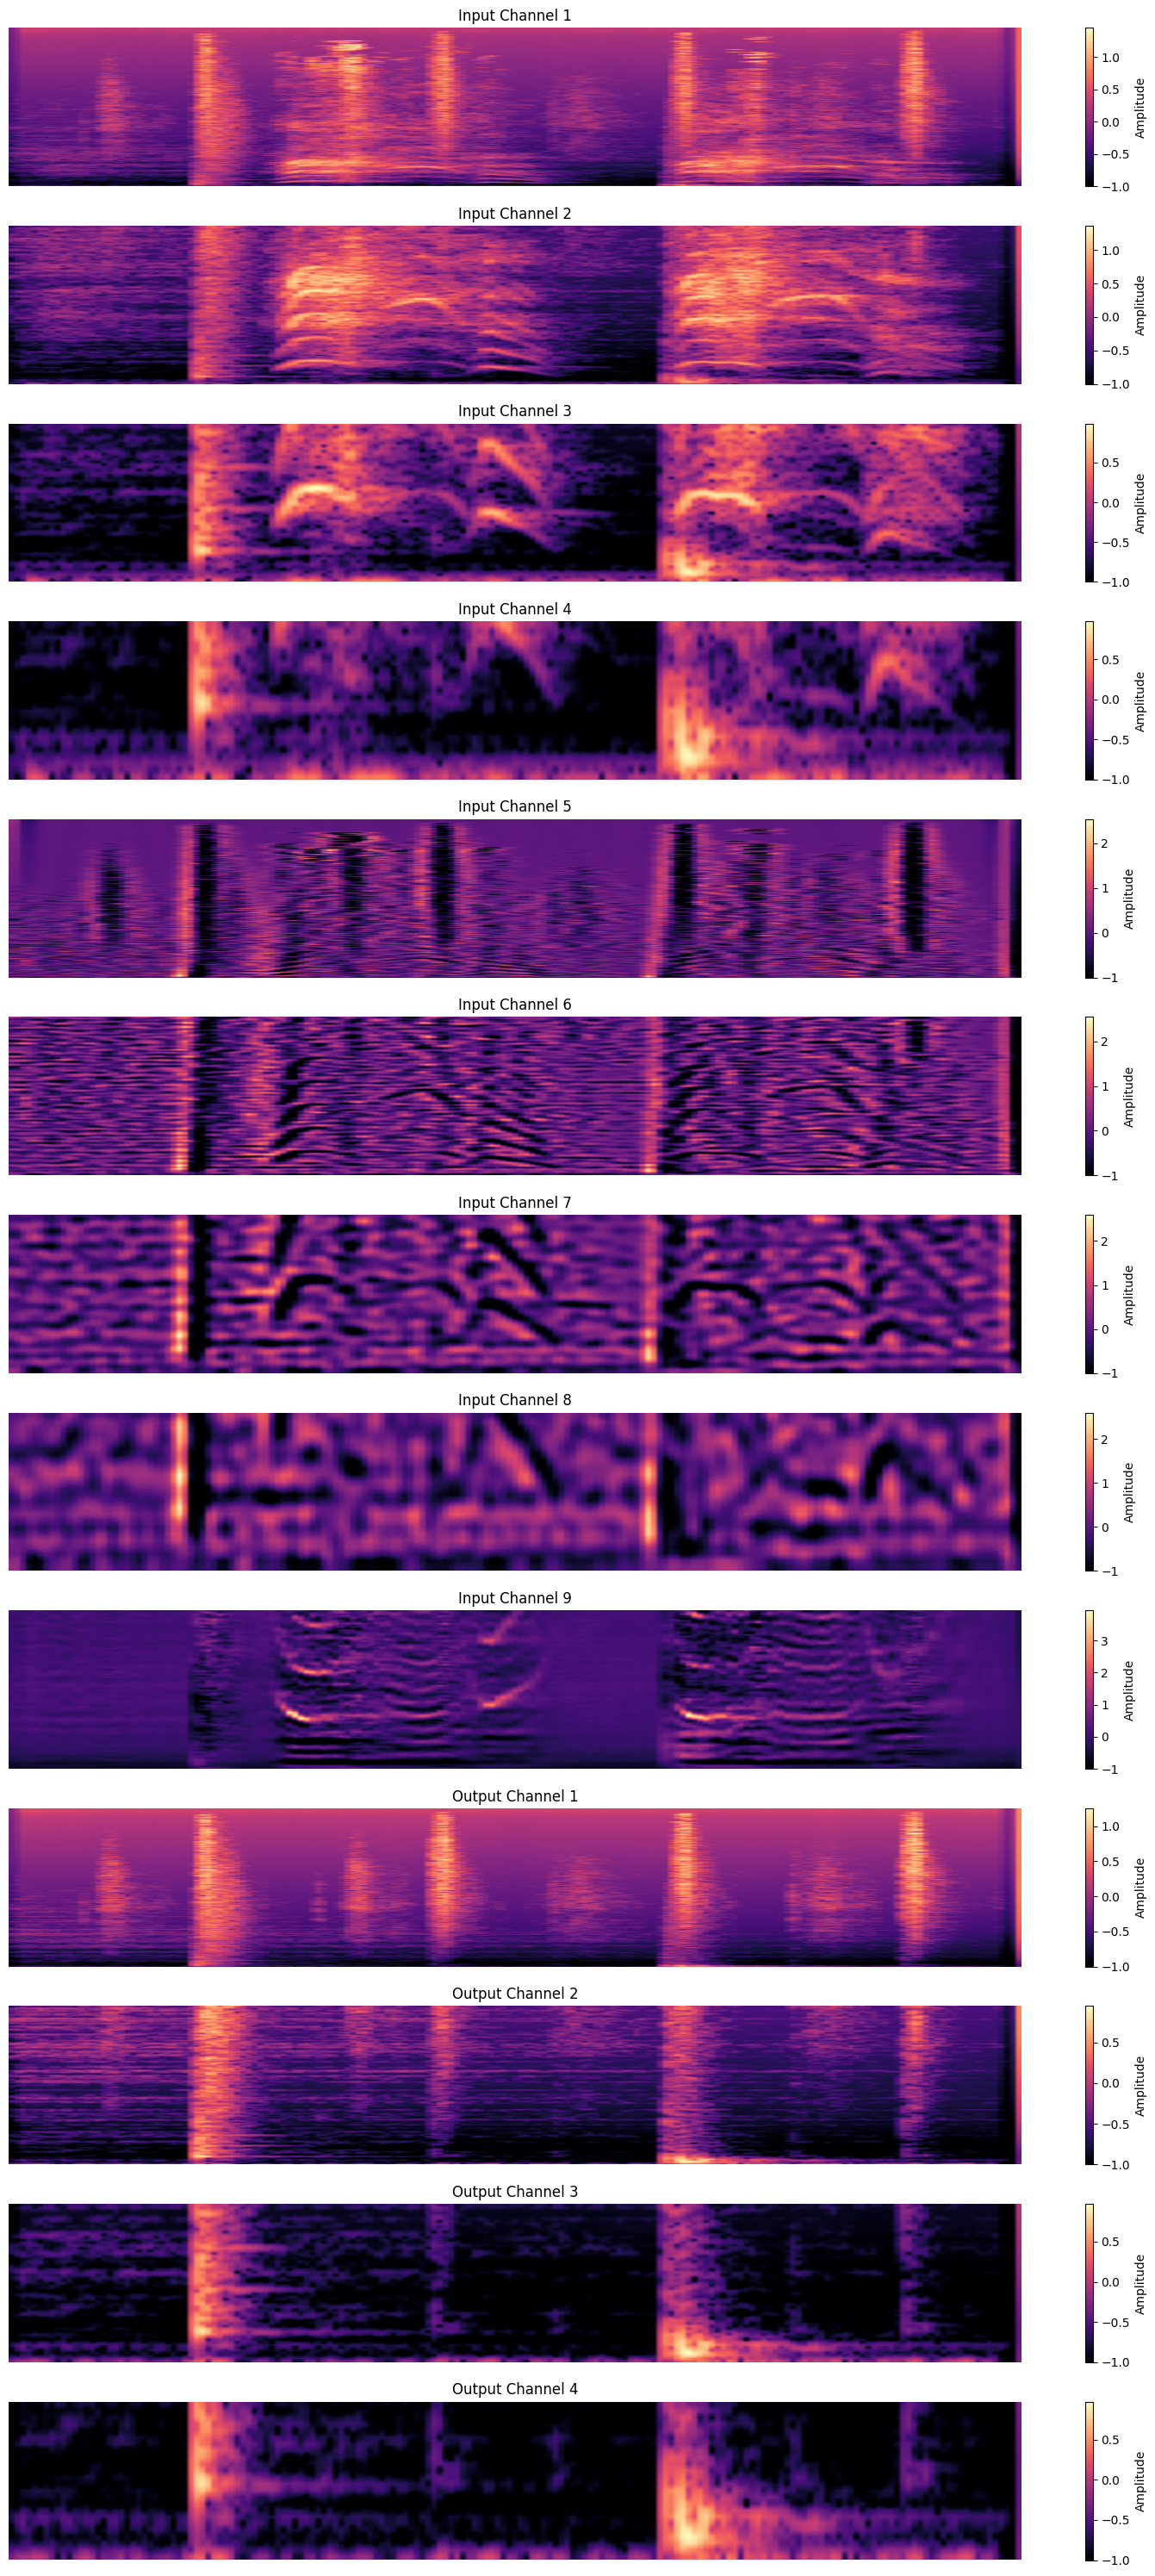

In [14]:
if LOAD_DATA:
  import matplotlib.pyplot as plt
  import torch
  import numpy as np
  import torch

  # Fetch a sample
  input_tensor, output_tensor, metadata = train_loader.train_dataset[51]

  print(metadata['snr_db'])

  # Convert to NumPy for plotting
  #input_array = np.clip(input_tensor.numpy(), -1, a_max=None)
  output_array = np.clip(output_tensor.numpy(), -1, a_max=None)
  input_array = np.clip(input_tensor.numpy(), -1, a_max=None)

  # remove negatve values
  #input_array = torch.clamp(input_array, min=0)  # Sets all negative values to 0
  print(np.shape(output_array))

  num_channels_out = output_array.shape[0]
  num_channels_in = input_array.shape[0]


  # Create subplots
  fig, axes = plt.subplots(num_channels_in + num_channels_out, 1, figsize=(15, 30))

  # Plot each input channel
  for i in range(num_channels_in):
      input = input_array[i]
      print(np.shape(input))
      print('Min, Max: ', np.min(input), np.max(input))
      im = axes[i].imshow(input, aspect='auto', cmap='magma')
      axes[i].invert_yaxis()

      axes[i].set_title(f"Input Channel {i+1}")
      axes[i].axis("off")

      # Add colorbar
      cbar = fig.colorbar(im, ax=axes[i], orientation="vertical")
      cbar.set_label("Amplitude")

    # Plot each input channel
  for i in range(num_channels_out):
      output = output_array[i]
      print('Min, Max: ', np.min(output), np.max(output))
      im = axes[num_channels_in + i].imshow(output, aspect='auto', cmap='magma')
      axes[num_channels_in + i].invert_yaxis()

      axes[num_channels_in + i].set_title(f"Output Channel {i+1}")
      axes[num_channels_in + i].axis("off")

      # Add colorbar
      cbar = fig.colorbar(im, ax=axes[num_channels_in + i], orientation="vertical")
      cbar.set_label("Amplitude")

  plt.tight_layout()
  plt.show()


## Train Model

In [15]:
from audioautoencoder.loss import *
from audioautoencoder.utils import *

In [16]:
import torch

torch.cuda.empty_cache()

In [17]:
if load:
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
  #scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=2, T_mult=2, eta_min=eta_min)
  scheduler_loss = False
else:
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=2, T_mult=2, eta_min=eta_min)
  scheduler_loss = False

  #optimizer = None #torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
  #scheduler = None #torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
  #scheduler_loss = False #True

In [18]:
from audioautoencoder.plotting import *
from audioautoencoder.training import *

In [19]:
import torch
import gc

def clear_gpu_memory():
    """Clears all allocated GPU memory in PyTorch."""
    torch.cuda.empty_cache()  # Clears cache
    gc.collect()  # Runs Python garbage collector
    for i in range(torch.cuda.device_count()):
        torch.cuda.reset_peak_memory_stats(i)  # Resets peak memory tracking

clear_gpu_memory()

In [20]:
from audioautoencoder.training import *

# plot example inputs



Training on device: cuda
Epoch 1, Current Learning Rate: [0.001]


Training:   0%|          | 0/1078 [00:00<?, ?batch/s]

New kl loss beta: 0.0
Noise Level:  0.0


Validating: 100%|██████████| 270/270 [06:07<00:00,  1.36s/batch, loss=joint loss: 0.3683]


--------------------------------------------------
Epoch 1, Validation Loss: 0.3683
Validation score improved. Saving model to /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Denoising/Checkpoints_deeplabv3_resnet50_modified_-10-10/Autoencodermodel_earlystopping.pth.
Saved to Drive...


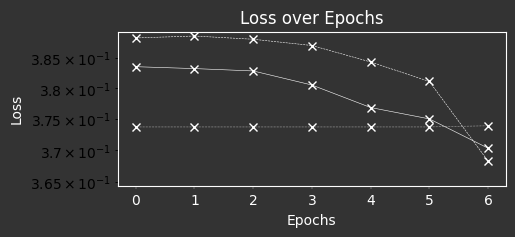

Epoch [1/100], Loss: 0.3704
--------------------------------------------------
Epoch 2, Current Learning Rate: [0.0009938503261272714]


Training:   0%|          | 0/1078 [00:00<?, ?batch/s]

New kl loss beta: 0.01
Noise Level:  0.0


Validating: 100%|██████████| 270/270 [06:15<00:00,  1.39s/batch, loss=joint loss: 0.3677]


--------------------------------------------------
Epoch 2, Validation Loss: 0.3677
Validation score improved. Saving model to /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Denoising/Checkpoints_deeplabv3_resnet50_modified_-10-10/Autoencodermodel_earlystopping.pth.
Saved to Drive...


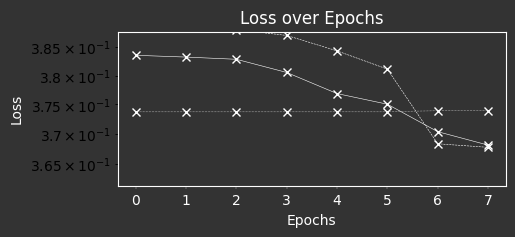

Epoch [2/100], Loss: 0.3681
--------------------------------------------------
Epoch 3, Current Learning Rate: [0.0009755527298894294]


Training:   0%|          | 0/1078 [00:00<?, ?batch/s]

New kl loss beta: 0.02
Noise Level:  0.0


Validating: 100%|██████████| 270/270 [06:02<00:00,  1.34s/batch, loss=joint loss: 0.3673]


--------------------------------------------------
Epoch 3, Validation Loss: 0.3673
Validation score improved. Saving model to /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Denoising/Checkpoints_deeplabv3_resnet50_modified_-10-10/Autoencodermodel_earlystopping.pth.
Saved to Drive...


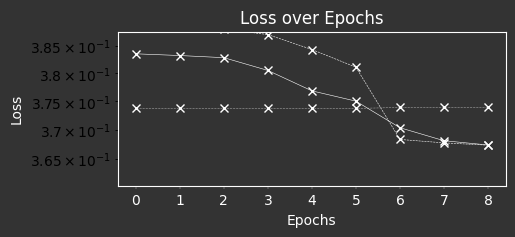

Epoch [3/100], Loss: 0.3673
--------------------------------------------------
Epoch 4, Current Learning Rate: [0.0009455577588320898]


Training:   0%|          | 0/1078 [00:00<?, ?batch/s]

New kl loss beta: 0.03
Noise Level:  0.0


Validating: 100%|██████████| 270/270 [05:56<00:00,  1.32s/batch, loss=joint loss: 0.3668]


--------------------------------------------------
Epoch 4, Validation Loss: 0.3668
Validation score improved. Saving model to /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Denoising/Checkpoints_deeplabv3_resnet50_modified_-10-10/Autoencodermodel_earlystopping.pth.
Saved to Drive...


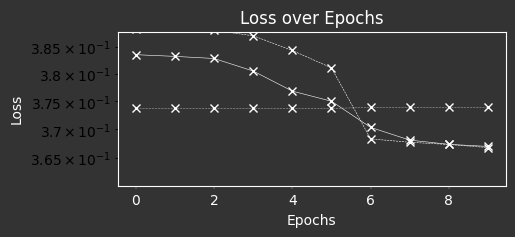

Epoch [4/100], Loss: 0.3670
--------------------------------------------------
Epoch 5, Current Learning Rate: [0.0009046039886902864]


Training:   0%|          | 0/1078 [00:00<?, ?batch/s]

New kl loss beta: 0.04
Noise Level:  0.0


Validating: 100%|██████████| 270/270 [06:03<00:00,  1.34s/batch, loss=joint loss: 0.3666]


--------------------------------------------------
Epoch 5, Validation Loss: 0.3666
Validation score improved. Saving model to /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Denoising/Checkpoints_deeplabv3_resnet50_modified_-10-10/Autoencodermodel_earlystopping.pth.
Saved to Drive...


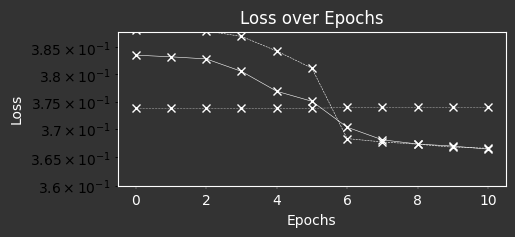

Epoch [5/100], Loss: 0.3664
--------------------------------------------------
Epoch 6, Current Learning Rate: [0.0008536998372026805]


Training:   0%|          | 0/1078 [00:00<?, ?batch/s]

New kl loss beta: 0.05
Noise Level:  0.0


Validating:  97%|█████████▋| 261/270 [05:47<00:12,  1.35s/batch, loss=joint loss: 0.3660]

In [ ]:
if train:
  trainer = DenoisingTrainer(
      model=model, noisy_train_loader=train_loader.train_loader, noisy_val_loader=train_loader.val_loader,
      SNRdB=SNRdB, output_path=output_path, epochs=epochs, learning_rate=learning_rate,
      load=load, warm_start=warm_start, train=train, verbose=False, accumulation_steps=accumulation_steps, load_path=load_path,
      base_lr=base_lr, max_lr=max_lr, gamma=gamma, optimizer=optimizer, scheduler=scheduler, scheduler_loss=scheduler_loss,
      max_noise=0.00, noise_epochs=5, train_diffusion=train_diffusion
  )
  trainer.train_or_evaluate()
  model = trainer.get_model()

  # I need a flat load model function somewhere, as now I need to define a train loader before I can load a model
  csv_file_path = output_path + "training_log.csv"
  plot_training_log(csv_file_path)

___